<a href="https://colab.research.google.com/github/gabrielfea/EstudokNN-/blob/main/Projeto2_Gabriel_Freitas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PROJETO 02 - DISCIPLINA DE RECONHECIMENTO DE PADRÕES - MESTRADO UDESC**

GABRIEL VINICIUS BOIN FREITAS

Considere as amostras de uma base de dados, cada qual com um vetor de características e rótulo
verdadeiro da classe. Dado um arquivo contendo uma base com N amostras, faça um programa para
dividir esta base em três conjuntos; Z1 - treinamento; Z2 - avaliação, e Z3 - teste; gravando eles em
arquivos separados. O número de amostras em cada conjunto deve ser definido por parâmetros do
programa. Use um percentual para cada conjunto (e.g., 25% para Z1, 25% para Z2, e 50% para Z3),
mas garanta que este percentual também é respeitado para cada classe.
Considere o classificador Knn (K nearest neighbors ou K vizinhos mais próximos em Z1).
Para classificar uma amostra s de avaliação (ou de teste) com este classificador, você deve buscar as
K amostras mais próximas de s em Z1 de acordo com a distância Euclideana entre os respectivos
vetores de características. O rótulo mais frequente entre as K amostras mais próximas é o rótulo
usado para classificar s. Se este não for o rótulo verdadeiro de s, então você conta um erro.
Seu objetivo é projetar um classificador usando os conjuntos Z1 e Z2 de forma a minimizar o
número de erros em Z2. Uma vez projetado, você estará assumindo que este classificador também
obterá um erro baixo em Z3. Esta metodologia é interessante por duas razões: (1) Ela demonstra a
capacidade de aprendizado com os erros, usando as amostras de Z2, e (2) também demonstra a
robustez do classificador, no caso dos erros em Z3 serem da mesma ordem de grandeza dos erros em
Z2.

Para este projeto você pode selecionar no mínimo 5 bases de dados do site
http://archive.ics.uci.edu/ml/
Ex.: Iris, Car Evaluation, Contraceptive Method Choice, Haberman's Survival, Pima Indians
Diabetes, Dermatology, Ionosphere, Mammographic Masses, Abalone, Magic, Liver Disorders,
Wine, Balance Scale,...

#Download das bases escolhidas:

In [1]:
!pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset / escolhi somente bases com features numéricas para facilitar e não ter que tratar as categóricas
iris = fetch_ucirepo(id=53)
rice_cammeo_and_osmancik = fetch_ucirepo(id=545)
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)
letter_recognition = fetch_ucirepo(id=59)
glass_identification = fetch_ucirepo(id=42)
optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80)
wine_quality = fetch_ucirepo(id=186)
sepsis_survival_minimal_clinical_records = fetch_ucirepo(id=827)

datasets = [iris,rice_cammeo_and_osmancik,breast_cancer_wisconsin_diagnostic,letter_recognition,glass_identification,optical_recognition_of_handwritten_digits,wine_quality,sepsis_survival_minimal_clinical_records]
names = ["Iris","Rice Cammeoa and Osmancik","Breast cancer Wisconsin diagnostic","Letter Recognition","Glass identification","Optical recognition of handwritten digits","Wine quality","Sepsis survival minimal clinical records"]

# Função de Split em z1 (train), z2 (test) e z3 (validation) - respeitando a quantidade por classe - parâmetro stratify:

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np

def split(df, silent):
  perc_train = 0.25
  perc_test = 0.25
  perc_val = 0.50

  #padroniza com min_max_scaler
  X = df.data.features
  X = X.values
  min_max_scaler = preprocessing.MinMaxScaler()
  X_scaled = min_max_scaler.fit_transform(X)
  X = pd.DataFrame(X_scaled)

  #transforma y em categorias
  y = df.data.targets.astype('category')

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=perc_test, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=perc_val/(1-perc_test), stratify=y_train)
  z1 = pd.concat([X_train, y_train], axis=1)
  z2 = pd.concat([X_test, y_test], axis=1)
  z3 = pd.concat([X_val, y_val], axis=1)
  distribuicao = {"z1":len(z1), "z2": len(z2), "z3": len(z3)}
  if silent == False:
    print(f"Train: {perc_train*100}% |Test: {perc_test*100}% |Validation: {perc_val*100}%")
    print(distribuicao)
  return z1, z2 , z3


# Função que determina tamanho de K:

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
def encontra_k(z1, z2,silent):
  k_min = 1
  k_max = len(z1) if len(z1) <= 20 else 20
  k_interval = 2
  dominio = range(k_min, k_max, k_interval)
  X = z1.iloc[:,:-1]
  y = z1.iloc[:,-1]
  X_hat = z2.iloc[:,:-1]
  y_hat = z2.iloc[:,-1]
  melhor_k = {}
  for i in dominio:
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X, y)
    melhor_k[i] = accuracy_score(y_hat, neigh.predict(X_hat))
  melhor_k = sorted(melhor_k.items(), key=lambda x:x[1])
  if silent == False:
    print(f"O melhor k foi {melhor_k[-1][0]}, que obteve acurácia de {np.round(100*melhor_k[-1][1],2)}%.")
  k = melhor_k[-1][0]
  return k

# Função que conta quantos erros em z2, baseado no z1 atual e retorna a lista de índices dos elementos a serem alterados com z1 (respeitando as classes):

In [5]:
import numpy as np
def analisa_z1(z1,z2,k,silent):
  X = z1.iloc[:,:-1]
  y = z1.iloc[:,-1]
  X_hat = z2.iloc[:,:-1]
  y_hat = z2.iloc[:,-1]
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(X, y)
  compara = pd.DataFrame()
  compara.index = X_hat.index
  compara["prev"] = neigh.predict(X_hat)
  compara["ground_truth"] = y_hat
  compara["erro"] = compara["prev"] == compara["ground_truth"]
  lista_erro = [i for i in compara[compara["erro"]==False].index]
  num_erro = compara[compara["erro"]==False]["erro"].count()
  classes = pd.DataFrame(compara[compara["erro"]==False].groupby("ground_truth")["ground_truth"].count())
  classes = classes[classes["ground_truth"]!=0]
  if silent == False:
    print(f"{num_erro} erro(s) encontrados nas previsões de índice(s): z2 {lista_erro}.")
    print()
    print(f"classes: {classes}")
  return z1,z2,lista_erro,num_erro,classes

# Função para guardar melhor z1

In [6]:
def guarda_z1_erros(guarda,z1,num_erro,ciclo):
  ciclo = ciclo
  if len(guarda) == 0:
    guarda.append(z1)
    guarda.append(num_erro)
    guarda.append(ciclo)
  elif guarda[1] > num_erro:
    guarda = [z1,num_erro,ciclo]
  return guarda

# Função que altera as linhas de z1 e z2 (sai as que não acertaram em z2 e vão para z1 sendo substituídas pela mesma classe):

In [7]:
def atualiza_z1_z2(z1,z2,lista_erro,classes):
  if len(lista_erro) >=1:
    z1 = pd.concat([z1,z2.loc[lista_erro]])
    z2 = z2.drop(lista_erro)
    for i in range(0,len(classes)):
      cl = classes.index[i]
      max = classes.loc[cl].values[0]
      index_remove = pd.DataFrame(z1[z1.iloc[:,-1]==classes.index[i]].iloc[0:max]).index
      if len(index_remove) >= 1:
        z2 = pd.concat([z2,pd.DataFrame(z1.loc[index_remove])])
        z1 = z1.drop(index_remove)
  return z1,z2

# Função que apresenta resultados:

In [8]:
%matplotlib inline
def result(z1,z3,k,n,metodo,silent):
  neigh = KNeighborsClassifier(n_neighbors=k)
  X = z1.iloc[:,:-1]
  y = z1.iloc[:,-1]
  X_hat = z3.iloc[:,:-1]
  y_true = z3.iloc[:,-1]
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(X, y)
  y_pred = neigh.predict(X_hat)
  acuracia = np.round(100*accuracy_score(y_true, y_pred),2)
  if silent == False:
    print("-------------------")
    print(f"Aplicando em z3 para {n}:")
    print(f"Acurácia: {acuracia}%")
    print("-------------------")
  from sklearn.metrics import confusion_matrix
  import seaborn as sns
  import plotly as plt
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  le.fit(y_true)
  if silent == False:
    cm = confusion_matrix(y_true, y_pred)
    import matplotlib.pyplot as plt
    f, ax = plt.subplots(figsize=(9, 6))
    ax.set_title(f"Matriz de confusão para {n} - {metodo}")
    sns.heatmap(cm,annot=True, xticklabels=le.classes_, yticklabels=le.classes_, fmt='d', ax=ax)
  return n, metodo, acuracia

# Método 1

Escreva um programa para ler os arquivos de Z1 e Z2, e descobrir qual valor de K (1,3,5,7,9,...)
minimiza os erros em Z2. Mantenha Z1 fixo e varie apenas K. Ao descobrir o valor ótimo de K, você
fixa este valor, e classifica as amostras de Z2 novamente, identificando as amostras erroneamente
classificadas, gravando Z1 e armazenando o número de erros. As amostras erroneamente
classificadas em Z2 são trocadas por amostras da mesma classe em Z1, e o processo se repete por T
iterações (T pode ser um parâmetro do programa junto com os nomes dos arquivos de Z1 e Z2). Ao
final de T iterações, você deve identificar qual instância de Z1 gerou o menor número de erros em
Z2. Este arquivo com a instancia melhor de Z1 deverá ser usado depois para testar seu classificador
em Z3.

# Método 2:

Note que você pode sugerir mudanças no projeto do seu classificador para termos um outro método.
Uma possibilidade é selecionar o melhor K a cada nova instância de Z1, de modo a garantir que o
par (Z1,K) será o que gera o erro mínimo em Z2. Neste caso, além de gravar Z1, você deve
armazenar o número de erros e o valor ótimo de K para este Z1. O método de escolha também pode
ser um parâmetro do programa.

In [9]:
def classificador(num_ciclos,silent=True,metodo=1):
  metodo= "Método 01" if metodo == 1 else "Método 02"
  silent = silent
  resultado = pd.DataFrame(columns=['Método', 'Base', 'Acurácia'])
  if silent == False:
    print(metodo)
  t=num_ciclos
  for i,n in zip(datasets,names):
    guarda = []
    if silent == False:
      print("-------------------")
      print("-------------------")
      print(f"\033[1m{n}\033[0m")
    z1, z2 , z3 = split(i,silent)
    k=encontra_k(z1, z2,silent)
    if silent == False:
      print("k:",k)
      print()
    for t in range(1,t+1):
      ciclo = t
      if silent == False:
        print("-------------------")
        print(f"Ciclo {t}")
        print("-------------------")
      z1,z2,lista_erro,num_erro,classes = analisa_z1(z1,z2,k,silent)
      guarda = guarda_z1_erros(guarda,z1,num_erro,ciclo)
      z1, z2 = atualiza_z1_z2(z1,z2,lista_erro,classes)
      if metodo == "Método 02":
        k=encontra_k(z1, z2,silent)
        if silent == False:
          print("k:",k)
          print()
    if silent == False:
      print()
      print()
      print("-------------------")
    melhor_erro = f"{guarda[1]} erro(s)."
    melhor_ciclo = f"Ciclo {guarda[2]} de {t} ciclo(s)"
    z1 = guarda[0]
    if silent == False:
      print(f"Número de erro(s) no melhor ciclo: {melhor_erro}")
      print(f"Melhor Ciclo: {melhor_ciclo}")
      #print(f"z1 escolhida: {z1}")
    n, metodo, acuracia = result(z1,z3,k,n,metodo,silent)
    resultado.loc[len(resultado)] = [metodo, n, acuracia]

  return resultado

# Testes com o classificador para comparar os métodos 1 e 2.
Para comparar os métodos 1 e 2 de projeto, você deve testar o classificador em Z3 e verificar qual
método levou ao menor número de erros. Faça um programa para ler o arquivo de Z3, o melhor
arquivo de Z1 (que pode ser um do método 1 ou do método 2) e o K ótimo. Classifique as amostras
de Z3 e meça o número de erros. Para que sua medida seja confiável, repita o processo inteiro, desde
a divisão da base em três conjuntos, e meça o erro em Z3 várias vezes (30, por exemplo). Calcule a
média e o desvio padrão desta medida. Um método pode ser dito melhor que o outro se não houver
superposição entre seus intervalos de erro em torno das médias.

In [12]:
def compara_metodos(num_execucoes):
  execucao = 0
  num_ciclos = 5
  df = pd.DataFrame()
  while execucao < num_execucoes:
    print("=========================================================")
    print(f"{execucao+1} execução(ões) de {num_execucoes} execuções.")
    print("=========================================================")
    df1 = classificador(num_ciclos,silent=True,metodo=1)
    df2 = classificador(num_ciclos,silent=True,metodo=2)
    if len(df) == 0:
      df = pd.concat([df1, df2], ignore_index=True)
    else:
      df_a = pd.concat([df1, df2], ignore_index=True)
      df = pd.concat([df_a, df], ignore_index=True)
    execucao += 1
  return df

In [13]:
df = compara_metodos(30)

1 execução(ões) de 30 execuções.
2 execução(ões) de 30 execuções.
3 execução(ões) de 30 execuções.
4 execução(ões) de 30 execuções.
5 execução(ões) de 30 execuções.
6 execução(ões) de 30 execuções.
7 execução(ões) de 30 execuções.
8 execução(ões) de 30 execuções.
9 execução(ões) de 30 execuções.
10 execução(ões) de 30 execuções.
11 execução(ões) de 30 execuções.
12 execução(ões) de 30 execuções.
13 execução(ões) de 30 execuções.
14 execução(ões) de 30 execuções.
15 execução(ões) de 30 execuções.
16 execução(ões) de 30 execuções.
17 execução(ões) de 30 execuções.
18 execução(ões) de 30 execuções.
19 execução(ões) de 30 execuções.
20 execução(ões) de 30 execuções.
21 execução(ões) de 30 execuções.
22 execução(ões) de 30 execuções.
23 execução(ões) de 30 execuções.
24 execução(ões) de 30 execuções.
25 execução(ões) de 30 execuções.
26 execução(ões) de 30 execuções.
27 execução(ões) de 30 execuções.
28 execução(ões) de 30 execuções.
29 execução(ões) de 30 execuções.
30 execução(ões) de 30 

In [36]:
df2 = df.groupby(["Método","Base"]).mean().sort_values(by=["Base"],ascending=False)
df2["Std"]= df.groupby(["Método","Base"]).std()
df2

,,Acurácia,Std
Método,Base,,
Método 01,Wine quality,51.793667,1.057640
Método 02,Wine quality,51.122667,1.076059
Método 01,Sepsis survival minimal clinical records,92.629667,0.001826
Método 02,Sepsis survival minimal clinical records,92.630000,0.000000
Método 01,Rice Cammeoa and Osmancik,92.113333,0.630437
Método 02,Rice Cammeoa and Osmancik,92.203000,0.407559
Método 01,Optical recognition of handwritten digits,97.999333,0.222849
Método 02,Optical recognition of handwritten digits,97.902667,0.315539
Método 01,Letter Recognition,92.807000,0.242603


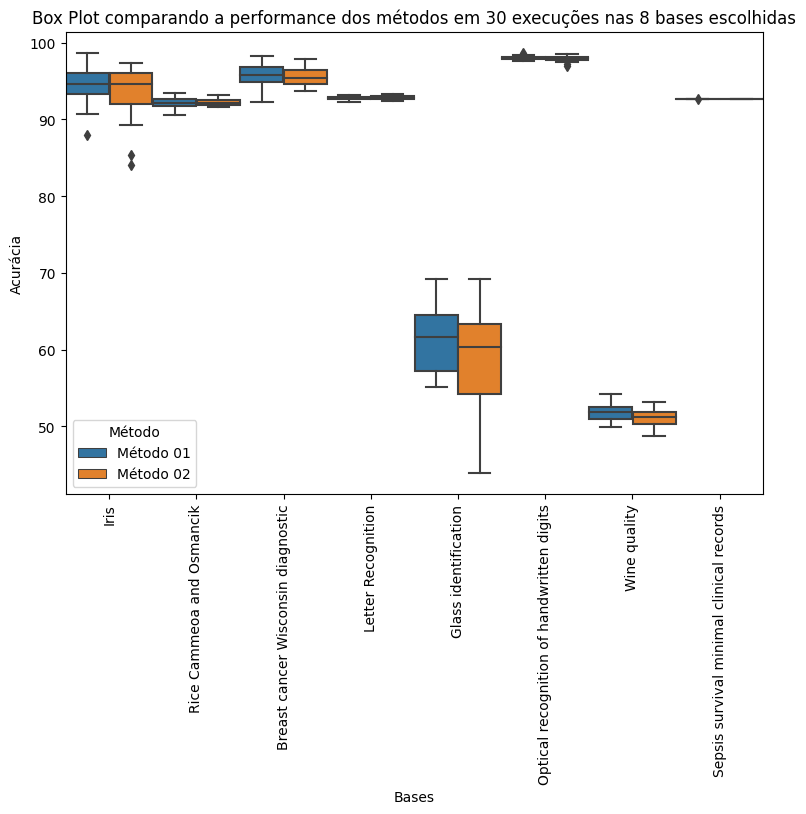

In [78]:
from seaborn.matrix import axis_ticklabels_overlap
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(9, 6))
ax.set_title(f"Box Plot comparando a performance dos métodos em 30 execuções nas 8 bases escolhidas")
sns.boxplot(df, x="Base", y="Acurácia", hue="Método", width=1)
ax.set_ylabel("Acurácia")
ax.set_xlabel("Bases")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

Em geral, os dois métodos se comportaram de forma semelhante sobre a acurácia ,conforme o boxplots acima. Uma performance não estatísticamente superior vista no método 01 em algumas das 8 bases escolhidas.

# Execução de uma vez para cada um dos métodos com o "modo silencioso" desligado:

Método 01
-------------------
-------------------
Iris
Train: 25.0% |Test: 25.0% |Validation: 50.0%
{'z1': 37, 'z2': 38, 'z3': 75}
O melhor k foi 13, que obteve acurácia de 100.0%.
k: 13

-------------------
Ciclo 1
-------------------
0 erro(s) encontrados nas previsões de índice(s): z2 [].

classes: Empty DataFrame
Columns: [ground_truth]
Index: []
-------------------
Ciclo 2
-------------------
0 erro(s) encontrados nas previsões de índice(s): z2 [].

classes: Empty DataFrame
Columns: [ground_truth]
Index: []
-------------------
Ciclo 3
-------------------
0 erro(s) encontrados nas previsões de índice(s): z2 [].

classes: Empty DataFrame
Columns: [ground_truth]
Index: []
-------------------
Ciclo 4
-------------------
0 erro(s) encontrados nas previsões de índice(s): z2 [].

classes: Empty DataFrame
Columns: [ground_truth]
Index: []
-------------------
Ciclo 5
-------------------
0 erro(s) encontrados nas previsões de índice(s): z2 [].

classes: Empty DataFrame
Columns: [ground_trut

,Método,Base,Acurácia
0,Método 01,Iris,89.33
1,Método 01,Rice Cammeoa and Osmancik,92.49
2,Método 01,Breast cancer Wisconsin diagnostic,92.96
3,Método 01,Letter Recognition,92.48
4,Método 01,Glass identification,39.25
5,Método 01,Optical recognition of handwritten digits,98.08
6,Método 01,Wine quality,52.72
7,Método 01,Sepsis survival minimal clinical records,92.63


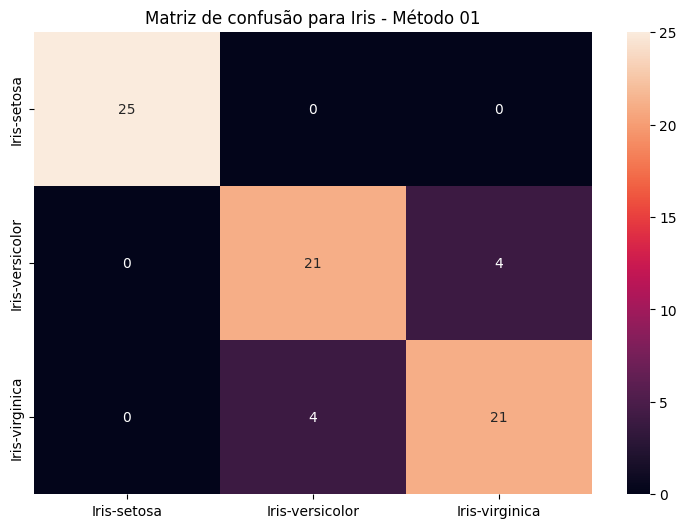

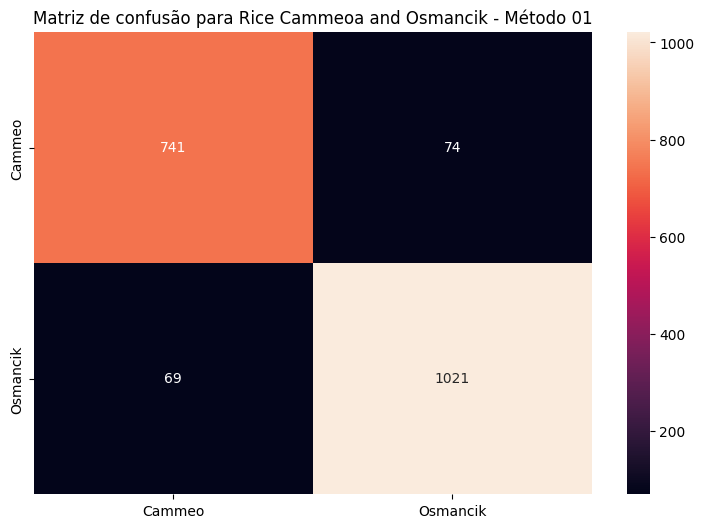

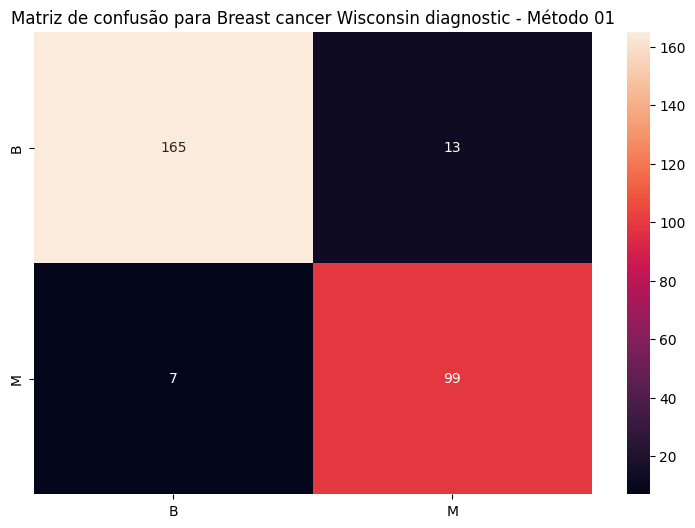

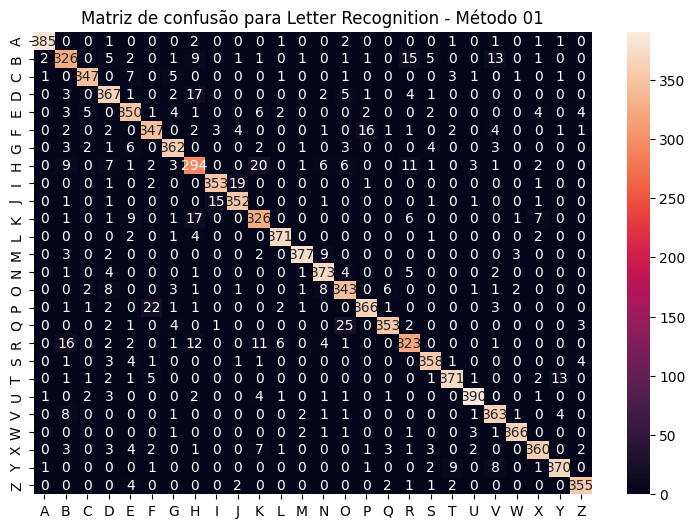

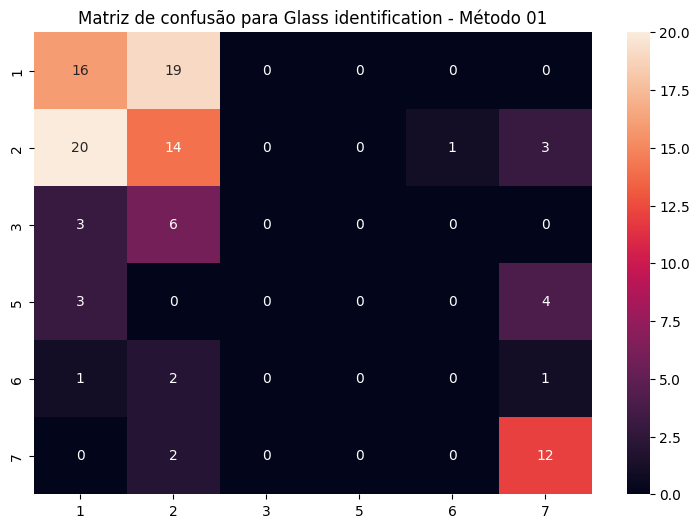

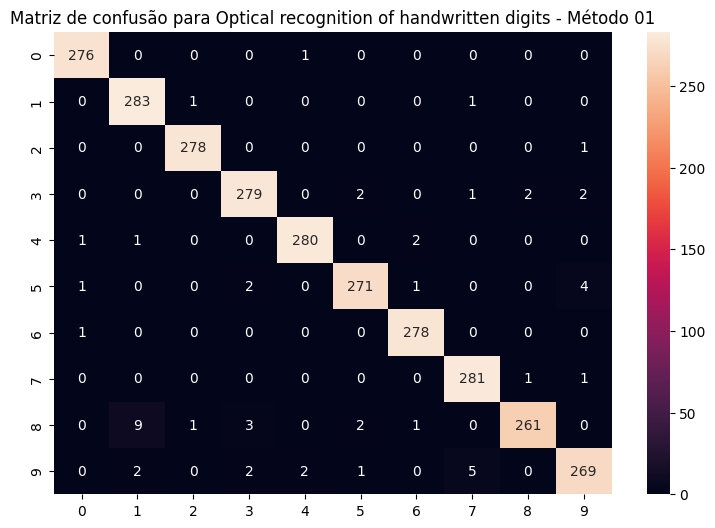

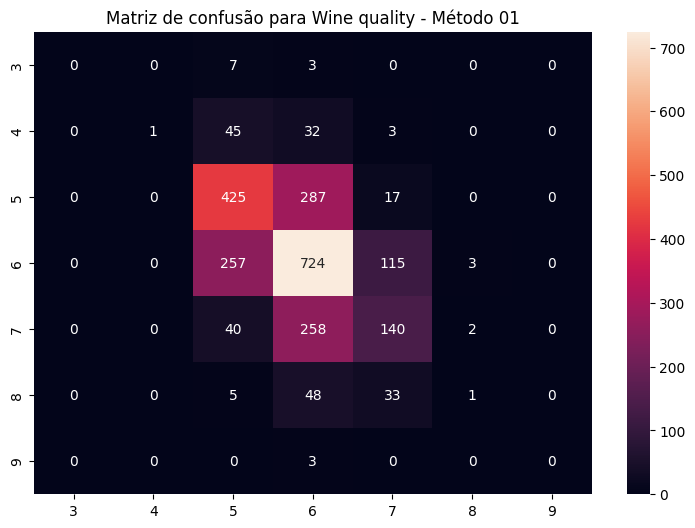

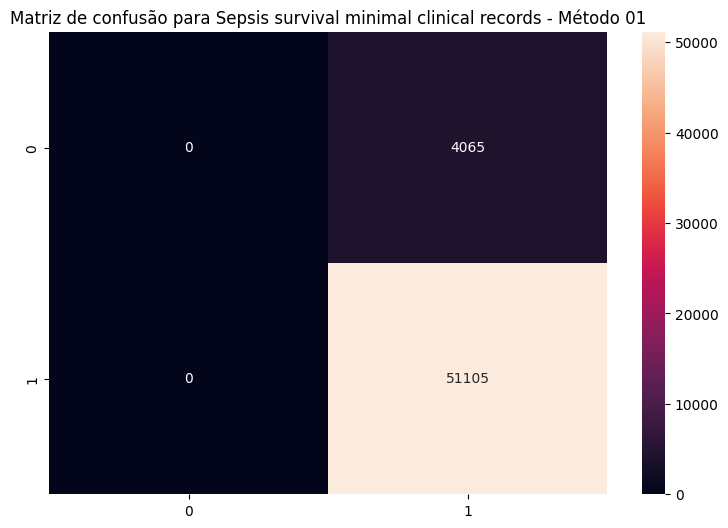

In [79]:
classificador(5,silent=False,metodo=1)

Método 02
-------------------
-------------------
Iris
Train: 25.0% |Test: 25.0% |Validation: 50.0%
{'z1': 37, 'z2': 38, 'z3': 75}
O melhor k foi 7, que obteve acurácia de 97.37%.
k: 7

-------------------
Ciclo 1
-------------------
1 erro(s) encontrados nas previsões de índice(s): z2 [134].

classes:                 ground_truth
ground_truth                
Iris-virginica             1
O melhor k foi 9, que obteve acurácia de 97.37%.
k: 9

-------------------
Ciclo 2
-------------------
1 erro(s) encontrados nas previsões de índice(s): z2 [121].

classes:                 ground_truth
ground_truth                
Iris-virginica             1
O melhor k foi 11, que obteve acurácia de 97.37%.
k: 11

-------------------
Ciclo 3
-------------------
1 erro(s) encontrados nas previsões de índice(s): z2 [116].

classes:                 ground_truth
ground_truth                
Iris-virginica             1
O melhor k foi 13, que obteve acurácia de 97.37%.
k: 13

-------------------
Ciclo 4
--

,Método,Base,Acurácia
0,Método 02,Iris,90.67
1,Método 02,Rice Cammeoa and Osmancik,91.97
2,Método 02,Breast cancer Wisconsin diagnostic,94.72
3,Método 02,Letter Recognition,92.84
4,Método 02,Glass identification,58.88
5,Método 02,Optical recognition of handwritten digits,98.01
6,Método 02,Wine quality,51.98
7,Método 02,Sepsis survival minimal clinical records,92.63


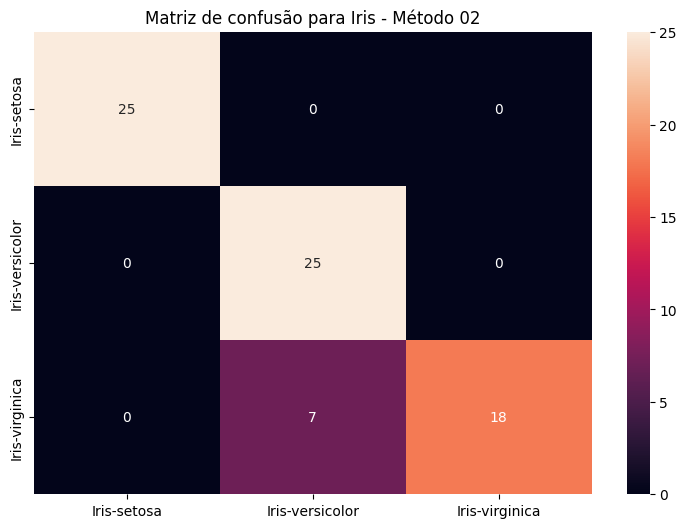

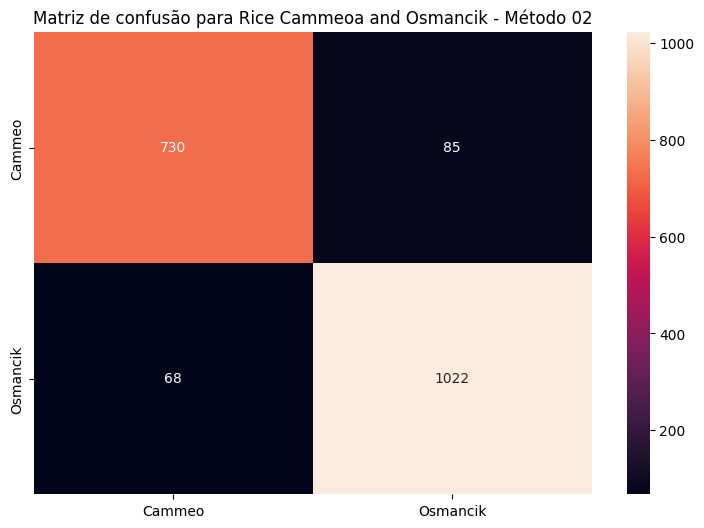

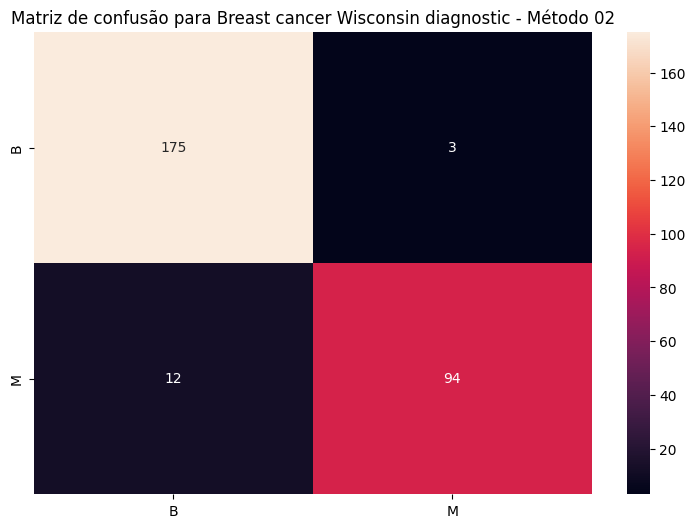

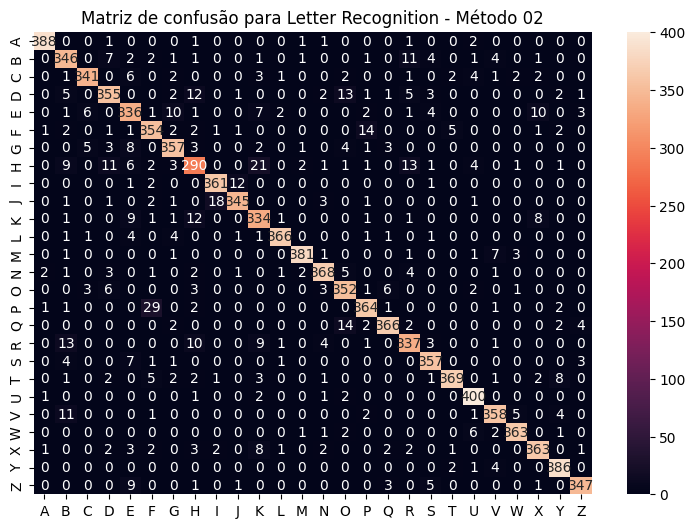

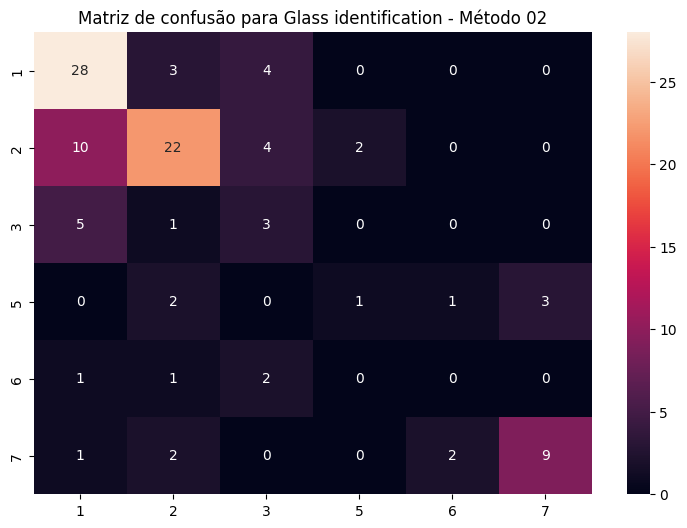

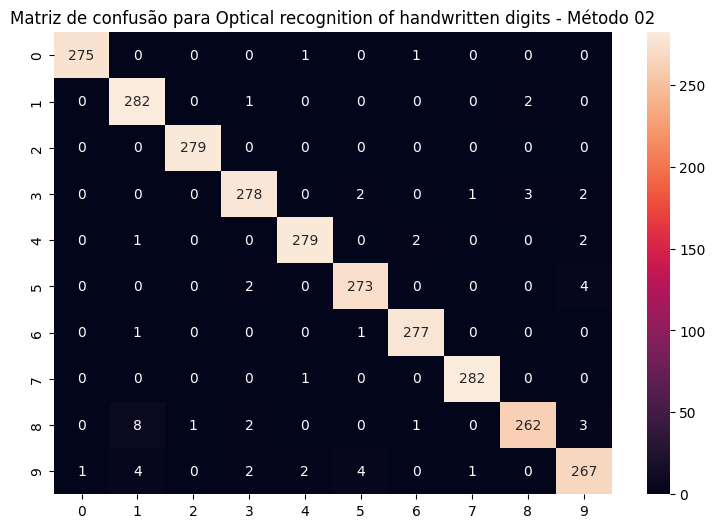

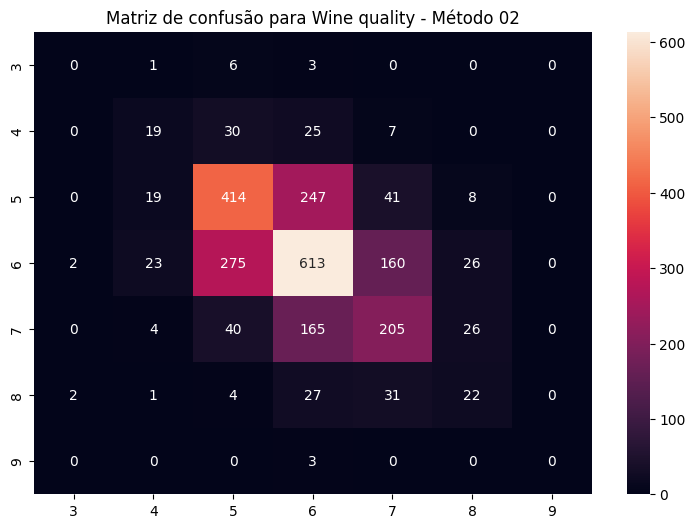

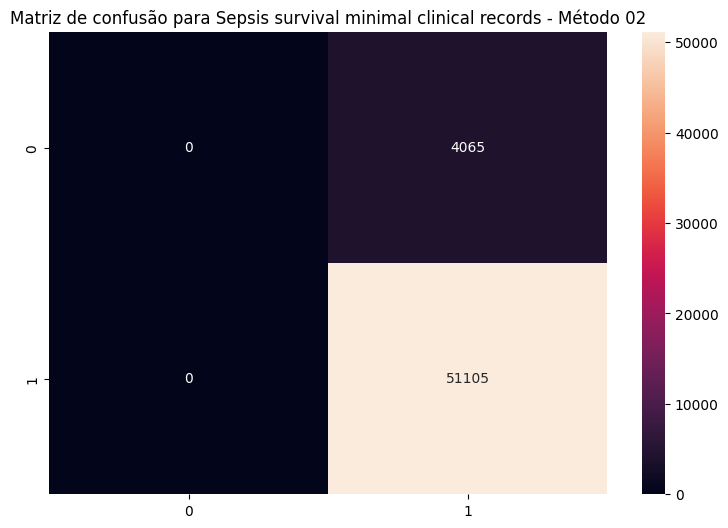

In [80]:
classificador(5,silent=False,metodo=2)